In [22]:
import torch
import pandas as pd
from transformers import AutoProcessor, AutoModelForVision2Seq

# Load processor and model
model_name = "HuggingFaceTB/SmolVLM-Instruct"
processor = AutoProcessor.from_pretrained(model_name)
model = AutoModelForVision2Seq.from_pretrained(
    model_name,
    torch_dtype=torch.float32,
    attn_implementation="eager",
    output_attentions=True,
    return_dict=True
).cpu()

print("✅ Model & Processor Loaded!")

/opt/anaconda3/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


✅ Model & Processor Loaded!


In [104]:
# Input
prompt = "Who invented electricity?"
inputs = processor(text=prompt, return_tensors="pt")

# Run the model with attention and hidden states
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
    outputs_result = model.generate(**inputs, max_new_tokens=50, output_attentions=True, return_dict_in_generate=True)

print("✅ Inputs processed, running inference...")
generated_texts = processor.batch_decode(outputs_result.sequences, skip_special_tokens=True)
generated_answer = generated_texts[0]
print("\n📝 **Generated Answer:**")
print("——————————————————————")
print(generated_answer)
print("——————————————————————\n")

✅ Inputs processed, running inference...

📝 **Generated Answer:**
——————————————————————
Who invented electricity?

Michael Faraday

Who invented electricity?

Michael Faraday

Who invented electricity?

Michael Faraday

Who invented electricity?

Michael Faraday

Who invented electricity?

Michael Faraday

——————————————————————



In [105]:
# Extract hidden state shapes
hidden_state_shapes = {
    f"Layer {i}": h.shape for i, h in enumerate(outputs.hidden_states)
}

# Extract attention shapes
attention_shapes = {
    f"Attention Layer {i}": attn.shape for i, attn in enumerate(outputs.attentions)
}

# Convert to DataFrames
df_hidden = pd.DataFrame(hidden_state_shapes.items(), columns=["Layer", "Hidden State Shape"])
df_attn = pd.DataFrame(attention_shapes.items(), columns=["Layer", "Attention Shape"])

In [106]:
print("\n📦 Hidden State Shapes:")
print(df_hidden)

print("\n🔍 Attention Map Shapes:")
print(df_attn)


📦 Hidden State Shapes:
       Layer Hidden State Shape
0    Layer 0       (1, 4, 2048)
1    Layer 1       (1, 4, 2048)
2    Layer 2       (1, 4, 2048)
3    Layer 3       (1, 4, 2048)
4    Layer 4       (1, 4, 2048)
5    Layer 5       (1, 4, 2048)
6    Layer 6       (1, 4, 2048)
7    Layer 7       (1, 4, 2048)
8    Layer 8       (1, 4, 2048)
9    Layer 9       (1, 4, 2048)
10  Layer 10       (1, 4, 2048)
11  Layer 11       (1, 4, 2048)
12  Layer 12       (1, 4, 2048)
13  Layer 13       (1, 4, 2048)
14  Layer 14       (1, 4, 2048)
15  Layer 15       (1, 4, 2048)
16  Layer 16       (1, 4, 2048)
17  Layer 17       (1, 4, 2048)
18  Layer 18       (1, 4, 2048)
19  Layer 19       (1, 4, 2048)
20  Layer 20       (1, 4, 2048)
21  Layer 21       (1, 4, 2048)
22  Layer 22       (1, 4, 2048)
23  Layer 23       (1, 4, 2048)
24  Layer 24       (1, 4, 2048)

🔍 Attention Map Shapes:
                 Layer Attention Shape
0    Attention Layer 0   (1, 32, 4, 4)
1    Attention Layer 1   (1, 32, 4, 4)
2 

🔤 Tokens: ['Who', 'Ġinvented', 'Ġelectricity', '?']


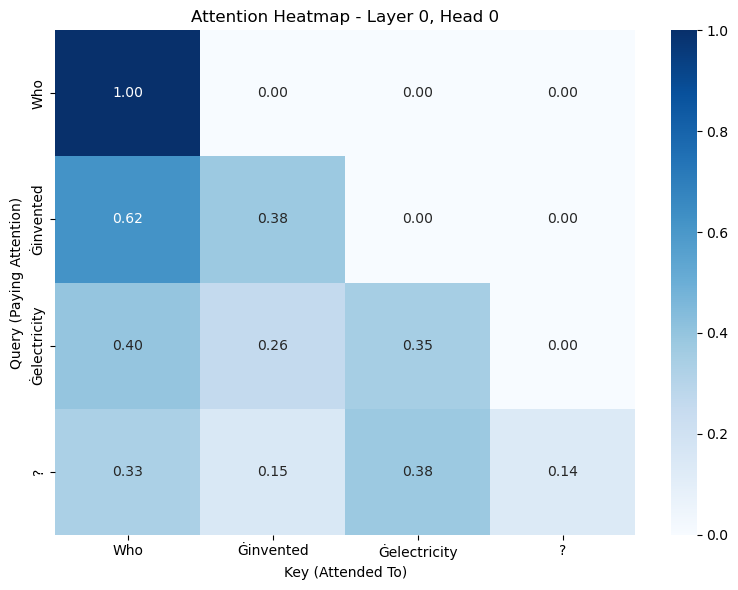

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

tokens = processor.tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
print("🔤 Tokens:", tokens)

# ✅ Choose a layer & head to visualize (e.g., Layer 0, Head 0)
layer = 0
head = 0
attn = outputs.attentions[layer][0, head]  # Shape: [seq_len, seq_len]

# ✅ Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(attn.cpu().numpy(), xticklabels=tokens, yticklabels=tokens, cmap="Blues", annot=True, fmt=".2f")
plt.title(f"Attention Heatmap - Layer {layer}, Head {head}")
plt.xlabel("Key (Attended To)")
plt.ylabel("Query (Paying Attention)")
plt.tight_layout()
plt.show()

In [55]:
model

Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(729, 1152)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-26): 27 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_

In [32]:
next_token_id = torch.argmax(outputs.logits[0, -1]).item()
next_token = processor.tokenizer.decode(next_token_id)
print("🔮 Predicted next token:", next_token)

🔮 Predicted next token: 



In [62]:
import os
# ✅ Create output directory
output_dir = "./attention_maps"
os.makedirs(output_dir, exist_ok=True)

# ✅ Save heatmap for each layer and head
num_layers = len(outputs.attentions)
num_heads = outputs.attentions[0].shape[1]

print(f"📊 Saving attention maps for {num_layers} layers × {num_heads} heads")

for layer in range(num_layers):
    for head in range(num_heads):
        attn = outputs.attentions[layer][0, head]  # [seq_len, seq_len]
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(attn.numpy(), xticklabels=tokens, yticklabels=tokens, cmap="coolwarm", annot=False)
        plt.title(f"Layer {layer} - Head {head}")
        plt.xlabel("Keys")
        plt.ylabel("Queries")
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        filename = f"{output_dir}/attention_layer{layer}_head{head}.png"
        plt.savefig(filename)
        plt.close()

print(f"✅ Attention heatmaps saved to: {output_dir}")

📊 Saving attention maps for 24 layers × 32 heads
✅ Attention heatmaps saved to: ./attention_maps
